In [1]:
import sys
sys.path.insert(0, '../')

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from typing import Tuple

from src.vg2signal import read_raw_vg_as_df, make_smoother, make_shoulder_getter, make_detilter
from src.load_dataset import load_dataset
from src.utils import tsen_pca_viz, verify_batch_label_dist, calculate_r2_score, calculate_per_diff, per_error, find_adj_score, perform_combat_normalization

from src.generate_dataset import v2signal_extra_features

In [2]:
# Load dataset
normalization    = False
standardize_type = 'mean_std' if normalization else 'none'
split            = False
combat_norm      = False
showFileName     = True

if split:
    (ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    (ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    (ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)

else:
    ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)

In [3]:
ML1_X['y']        = ML1_y.apply(lambda x: int(x.split('_')[-2].replace('cbz','')))
ML1_X['filename'] = ML1_y

ML2_X['y']        = ML2_y.apply(lambda x: int(x.split('_')[-2].replace('cbz','')))
ML2_X['filename'] = ML2_y

ML4_X['y']        = ML4_y.apply(lambda x: int(x.split('_')[-2].replace('cbz','')))
ML4_X['filename'] = ML4_y

In [4]:
ML1_X

,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)",y,filename
0,3.9270,74.8319,1.0592,1.060,0.057938,0.0056,0.0143,1.2795,-1.4044,2.6839,1.028,1.084,0.1159,8,2024_02_19_cbz08_16.txt
1,3.1525,71.2312,1.0596,1.060,0.048110,0.0045,0.0117,1.0918,-1.2233,2.3151,1.032,1.088,0.0962,8,2024_02_19_cbz08_02.txt
2,8.3259,169.0758,1.0579,1.060,0.126038,0.0119,0.0307,2.6995,-3.0750,5.7746,1.032,1.084,0.2521,16,2024_02_19_cbz16_16.txt
3,5.1395,117.3360,1.0714,1.076,0.081811,0.0073,0.0196,1.8314,-2.1638,3.9952,1.040,1.096,0.1636,16,2024_02_19_cbz16_02.txt
4,7.1913,170.9573,1.0578,1.060,0.109513,0.0103,0.0264,2.4115,-2.5560,4.9674,1.028,1.084,0.2190,16,2024_02_19_cbz16_03.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,1.2807,83.9311,1.0003,1.000,0.015235,0.0018,0.0040,0.4498,-0.5339,0.9837,0.960,1.064,0.0305,0,2024_02_19_cbz00_43.txt
126,5.1873,117.3580,1.0561,1.056,0.076948,0.0074,0.0189,1.7284,-1.8158,3.5442,1.028,1.084,0.1539,16,2024_02_19_cbz16_27.txt
127,5.8157,126.6233,1.0605,1.060,0.084659,0.0083,0.0210,1.8284,-2.0389,3.8673,1.024,1.092,0.1693,16,2024_02_19_cbz16_33.txt
128,3.4449,79.6460,1.0552,1.056,0.050678,0.0049,0.0124,1.0982,-1.0913,2.1895,1.032,1.084,0.1014,8,2024_02_19_cbz08_27.txt


Dataset Name:  ML1
lower boundary -0.0081875 upper boundary 0.0171125
Above_upper_bound: []  |  Lower_bound []


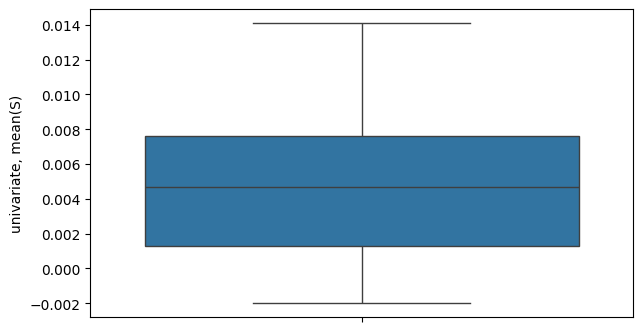


Dataset Name:  ML2
lower boundary -0.00795 upper boundary 0.01645
Above_upper_bound: []  |  Lower_bound []


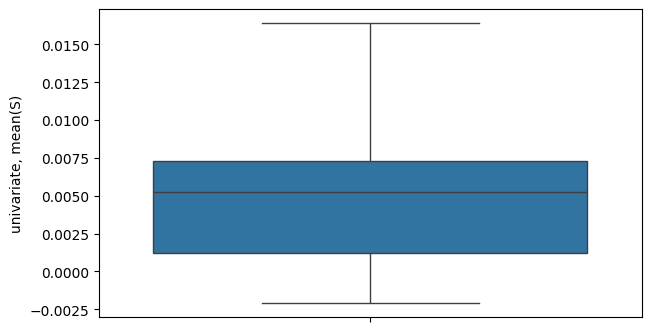


Dataset Name:  ML4
lower boundary -0.018224999999999998 upper boundary 0.033574999999999994
Above_upper_bound: []  |  Lower_bound []


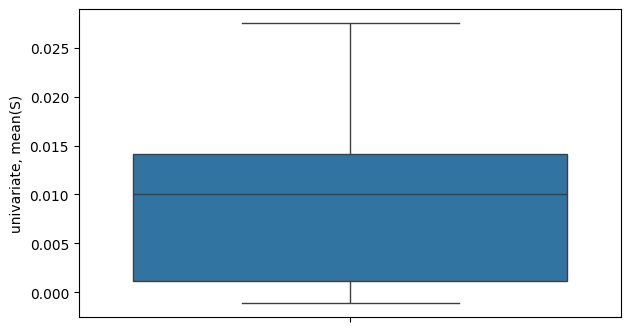

In [8]:
# data    = ML1_X.copy()
feature = 'univariate, mean(S)'
# sns.boxplot(data, x='y', y=feature)

# Find outliers 
for data, name in zip([ML1_X.copy(), ML2_X.copy(), ML4_X.copy()], ['ML1', 'ML2', 'ML4']):
    print("Dataset Name: ",name)
    
    Q1  = np.percentile(data[feature], q=25)
    Q3  = np.percentile(data[feature], q=75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    above_upper_bound = data[[feature, 'filename']][(data[feature]>upper_bound)]
    above_lower_bound = data[[feature, 'filename']][(data[feature]<lower_bound)]

    print("lower boundary", lower_bound, "upper boundary", upper_bound)
    print("Above_upper_bound:", above_upper_bound['filename'].values, " | ","Lower_bound",  above_lower_bound['filename'].values)
    
    plt.figure(figsize=(7,4))
    sns.boxplot(data, y=feature)
    plt.show()
    print()

In [ ]:
!pip install pyod

  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.1-py3-none-any.whl size=193267 sha256=b0c10e1efc58bd46d34568590af4c23634c5893dee3447779799feed2e4702ee
  Stored in directory: /Users/sangam/Library/Caches/pip/wheels/23/71/88/c2bab1baecb9b35930a6087879e2e07c5e663c480fea6c0479
Successfully built pyod
